# Get started

In this tutorial, we will run UNIFAN on the example data: Limb_Muscle in the Tabula Muris data. Please refer to **Download and Preprocess the Example Data** in the tutorials section for more details on how to prepare the example input data. 

**Table of Content**

1. [Set up parameters, training enviroments & outputs paths](#1)
2. [Load data & prepare get gene set matrix](#2) 
3. [Train gene set activity scores (r) model](#3)
4. [Pretrain AnnoCluster & initialize clustering](#4)
5. [Pretrain annotator (classification)](#5)
6. [Clustering using AnnoCluster together with annotator](#6)  

In [1]:
import os
import sys
import gc
import itertools

import torch
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import umap
from tqdm import tqdm
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split

from context import unifan 
from unifan.datasets import AnnDataset, NumpyDataset
from unifan.annocluster import AnnoCluster
from unifan.autoencoder import autoencoder
from unifan.classifier import classifier
from unifan.utils import getGeneSetMatrix
from unifan.trainer import Trainer

# 1. Set up parameters, training enviroments & outputs paths (user-specified)
<a id=1></a>

Users can specify the variables raleted to the datasets and the training conditions. Users can also specify the hyperparameters or just use the default values. This is the **<span style="color: red;">only</span>** step requiring users' inputs. 

We also initialize the file paths to all outputs. We will **describe the outputs** in the corresponding section below.

### Set up variables related to data 

In [2]:
project = "tabula_muris"
tissue = "Limb_Muscle"

data_filepath = f"../example/input/{tissue}_facts_processed_3m.h5ad"
output_path = "../example/output/"
gene_sets_path = "../gene_sets/"

label_name = "cell_ontology_class"
variable_gene_name = "highly_variable"

random_seed = 0

### Set up training conditions 

In [ ]:
use_cuda = False
num_workers = 8

# ------- no need to change the following -------
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    pin_memory = True
    non_blocking = True
else:
    pin_memory = False
    non_blocking = False

### Set hyperparameters values
1. The values in this tutorial are default hyperparameter values except for the number of epochs. Here we use 20 epochs for all training steps just for illustration purposes. The default values for the number of epochs are:
    1. num_epochs_classifier = 50 
    2. num_epochs_r = 70
    3. num_epochs_z = 50
    4. num_epochs_annocluster = 25

In [3]:
prior_name = "c5.go.bp.v7.4.symbols.gmt+c2.cp.v7.4.symbols.gmt+TF-DNA"
features_type = "gene_gene_sets"
alpha = 1e-2
beta = 1e-5
weight_decay = 1e-3
tau = 10
z_dim = 32

In [4]:
batch_size = 128

num_epochs_classifier = 20 
num_epochs_r = 20
num_epochs_z = 20
r_epoch = num_epochs_r - 1
z_epoch = num_epochs_z - 1
num_epochs_annocluster = 20

# configuration for the gene set activity scores model 
r_encoder_layers = 5
r_decoder_layers = 1  # need to fixed at 1 if using gene set matrix for decoder 
r_encoder_dim = 128
r_decoder_dim = 128  # actually not used if using gene set matrix for decoder 
rnetwork = 'non-negative'

# configuration for the AnnoCluster model
z_encoder_layers = 3
z_decoder_layers = 2
z_encoder_dim = 128
z_decoder_dim = 128

### Initialize paths to outputs (no need user-input)

Here we set up the paths to save the outputs. The outputs are:

1. Gene set activity scores model:
    1. Gene set activity scores model (input_r_ae_path)
    2. Gene set activity scores (input_r_path) & processed gene set activity scores
    3. Names of the features in the processed gene set activity scores (input_r_names_path)
    4. Training stats (i.e. Trainining loss, validation loss, loss for different terms etc.)
2. Pretrain results of the AnnoCluster model:
    1. Pretrained AnnoCluster model (input_ae_path)
    2. Initial z_e / low-dimensional representation of samples (input_z_path)
    3. Initialized cluster assignment (input_cluster_path)
    4. Training stats (i.e. Trainining loss, validation loss etc.)
3. Pretrain results of the annotator model:
    1. Pretrained annotator model
    2. Training stats (i.e. Trainining loss, validation loss etc.)
4. Training results of both annotator and AnnoCluster models: 
    1. Trained AnnoCluster and annotator model (saved in a single file) 
    2. Cluster assignments (annocluster_clusters_pre_{training epochs - 1}.npy)
    3. z_e / low-dimensional representation of samples (annocluser_{training epochs - 1}.npy)
    4. Training stats (i.e. Trainining loss, validation loss, loss for different terms, ARI and NMI based on the final clustering results etc.)
    
All models are saved as dictionaries, with keys "epoch", "state_dict" and "optimizer". For models trained together (final step, AnnoCluster with annotator), model 2 (annotator after the final step) is saved in "state_dict_2" and "optimizer_2".

In [ ]:
# ------ prepare for output
output_parent_path = f"{output_path}{project}/{tissue}/"

r_folder = f"{output_parent_path}r"
input_r_ae_path = os.path.join(r_folder, f"r_model_{r_epoch}.pickle")
input_r_path = os.path.join(r_folder, f"r_{r_epoch}.npy")
input_r_names_path = os.path.join(r_folder, f"r_names_{r_epoch}.npy")

pretrain_z_folder = f"{output_parent_path}pretrain_z"
input_z_path = os.path.join(pretrain_z_folder, f"pretrain_z_{z_epoch}.npy")
input_ae_path = os.path.join(pretrain_z_folder, f"pretrain_z_model_{z_epoch}.pickle")
input_cluster_path = os.path.join(pretrain_z_folder, f"cluster_{z_epoch}.npy")

pretrain_annotator_folder = f"{output_parent_path}pretrain_annotator"
annocluster_folder = f"{output_parent_path}annocluster_{features_type}"

# 2. Load data & prepare get gene set matrix
<a id=2></a>

In [8]:
# ------ load data
if features_type in ["gene", "gene_gene_sets"]:
    expression_only = AnnDataset(data_filepath, label_name=label_name, variable_gene_name=variable_gene_name)
    exp_variable_genes = expression_only.exp_variable_genes
    variable_genes_names = expression_only.variable_genes_names
else:
    expression_only = AnnDataset(data_filepath, label_name=label_name)
    exp_variable_genes = None
    variable_genes_names = None

genes_upper = expression_only.genes_upper
clusters_true = expression_only.clusters_true
N = expression_only.N
G = expression_only.G

In [9]:
# ------ generate gene_set_matrix
    
if '+' in prior_name:
    prior_names_list = prior_name.split('+')
    
    _matrix_list = []
    _keys_list = []
    for _name in prior_names_list:
        _matrix, _keys = getGeneSetMatrix(_name, genes_upper, gene_sets_path)
        _matrix_list.append(_matrix)
        _keys_list.append(_keys)

    gene_set_matrix = np.concatenate(_matrix_list, axis=0)
    keys_all = list(itertools.chain(*_keys_list))

    del _matrix_list
    del _keys_list
    gc.collect()

else:
    gene_set_matrix, keys_all = getGeneSetMatrix(prior_name, genes_upper, gene_sets_path)


GMT file c5.go.bp.v7.4.symbols.gmt loading ... 
7481
Number of genes in c5.go.bp.v7.4.symbols.gmt 13430
GMT file c2.cp.v7.4.symbols.gmt loading ... 
2922
Number of genes in c2.cp.v7.4.symbols.gmt 10556


In [10]:
# ------ set-up for the set cover loss
if beta != 0:
    # get the gene set matrix with only genes covered
    genes_covered = np.sum(gene_set_matrix, axis=0)
    gene_covered_matrix = gene_set_matrix[:, genes_covered != 0]
    gene_covered_matrix = torch.from_numpy(gene_covered_matrix).to(device, non_blocking=non_blocking).float()
    beta_list = torch.from_numpy(np.repeat(beta, gene_covered_matrix.shape[1])).to(device,
                                                                           non_blocking=non_blocking).float()

    del genes_covered
    gc.collect()
else:
    gene_covered_matrix = None

gene_set_dim = gene_set_matrix.shape[0]
gene_set_matrix = torch.from_numpy(gene_set_matrix).to(device, non_blocking=non_blocking)

# 3. Train gene set activity scores (r) model 
<a id=3></a>

Train the gene set activity scores model and infer the gene set activity scores. We will also process these scores by:

    1. keeping only gene sets used at least once by cells 
    2. adding also 2000 most variable genes, if use "gene_gene_sets" for features_type, which is the default

The outputs from this step are:

    1. Gene set activity scores model (input_r_ae_path)
    2. Gene set activity scores (input_r_path) & processed gene set activity scores
    3. Names of the features in the processed gene set activity scores (input_r_names_path)
    4. Training stats (i.e. Trainining loss, validation loss, loss for different terms etc.)

In [12]:
# ------ Train gene set activity scores (r) model ------
if features_type == "gene":
    z_gene_set = exp_variable_genes
    set_names = list(variable_genes_names)
else:

    model_gene_set = autoencoder(input_dim=G, z_dim=gene_set_dim, gene_set_dim=gene_set_dim,
                                 encoder_dim=r_encoder_dim, emission_dim=r_decoder_dim,
                                 num_layers_encoder=r_encoder_layers, num_layers_decoder=r_decoder_layers,
                                 reconstruction_network=rnetwork, decoding_network='geneSet',
                                 gene_set_table=gene_set_matrix, use_cuda=use_cuda)

    if os.path.isfile(input_r_path):
        print(f"Inferred r exists. No need to train the gene set activity scores model.")
        z_gene_set = np.load(input_r_path)
    else:
        if os.path.isfile(input_r_ae_path):
            model_gene_set.load_state_dict(torch.load(input_r_ae_path)['state_dict'])

        trainer = Trainer(dataset=expression_only, model=model_gene_set, model_name="r", batch_size=batch_size,
                          num_epochs=num_epochs_r, save_infer=True, output_folder=r_folder, num_workers=num_workers,
                          use_cuda=use_cuda)
        if os.path.isfile(input_r_ae_path):
            print(f"Inferred r model exists but r does not. Need to infer r and no need to train the gene set activity "
                  f"scores model.")
            z_gene_set = trainer.infer_r(alpha=alpha, beta=beta, beta_list=beta_list,
                                         gene_covered_matrix=gene_covered_matrix)
            np.save(input_r_path, z_gene_set)
        else:
            print(f"Start training the gene set activity scores model ... ")
            trainer.train(alpha=alpha, beta=beta, beta_list=beta_list, gene_covered_matrix=gene_covered_matrix)
            z_gene_set = np.load(input_r_path)

    z_gene_set = torch.from_numpy(z_gene_set)

    # filter r to keep only non-zero values
    idx_non_0_gene_sets = np.where(z_gene_set.numpy().sum(axis=0) != 0)[0]

    # get kepted gene set names
    set_names = np.array(keys_all)[idx_non_0_gene_sets]

    z_gene_set = z_gene_set[:, idx_non_0_gene_sets]
    print(f"Aftering filtering, we have {z_gene_set.shape[1]} genesets")

    # add also selected genes if using "gene_gene_sets"
    if features_type == "gene_gene_sets":
        z_gene_set = np.concatenate([z_gene_set, exp_variable_genes], axis=1)
        set_names = list(set_names) + list(variable_genes_names)
    else:
        pass

print(f"z_gene_set: {features_type}: {z_gene_set.shape}")
print(f"z_gene_set: {features_type}: {len(set_names)}")

# save feature names
input_r_names_path = f"{input_r_names_path}_filtered_{features_type}.npy"
np.save(input_r_names_path, set_names)

# save processed features
input_r_path = f"{input_r_path}_filtered_{features_type}.npy"
np.save(input_r_path, z_gene_set)
gene_set_dim = z_gene_set.shape[1]

try:
    z_gene_set = z_gene_set.numpy()
except AttributeError:
    pass

  0%|          | 0/9 [00:00<?, ?it/s]

Start training the gene set activity scores model ... 
Current epoch: 0
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Start evaluating train ...


  0%|          | 0/9 [00:00<?, ?it/s]

Finish evaluating train...
Start evaluating val...
Finish evaluating val...
Current epoch: 1
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 2
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 3
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 4
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 5
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 6
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 7
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 8
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 9
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 10
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Start evaluating train ...


  0%|          | 0/9 [00:00<?, ?it/s]

Finish evaluating train...
Start evaluating val...
Finish evaluating val...
Current epoch: 11
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 12
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 13
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 14
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 15
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 16
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 17
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 18
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 19
Start training...


100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


Start inferring ...
Finish inferring ...
Aftering filtering, we have 1089 genesets
z_gene_set: gene_gene_sets: (1102, 3089)
z_gene_set: gene_gene_sets: 3089


### visualize & evaluate the gene set activity scores 

    1. visualize gene set activity scores using UMAP
    2. evaluate the scores quality by performing leiden clustering using the scores and comparing with ground truth (if available); this clustering result will not be used by downstream tasks

R: ARI for smaller cluster: 0.5540936568251427
R: NMI for smaller cluster: 0.7328877915085344


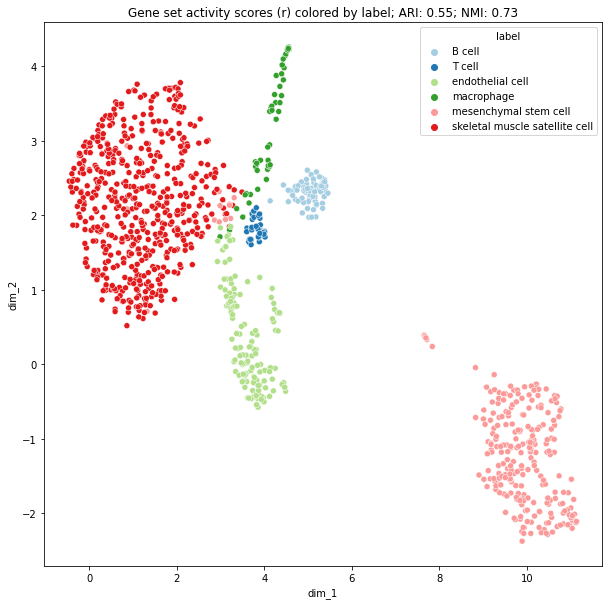

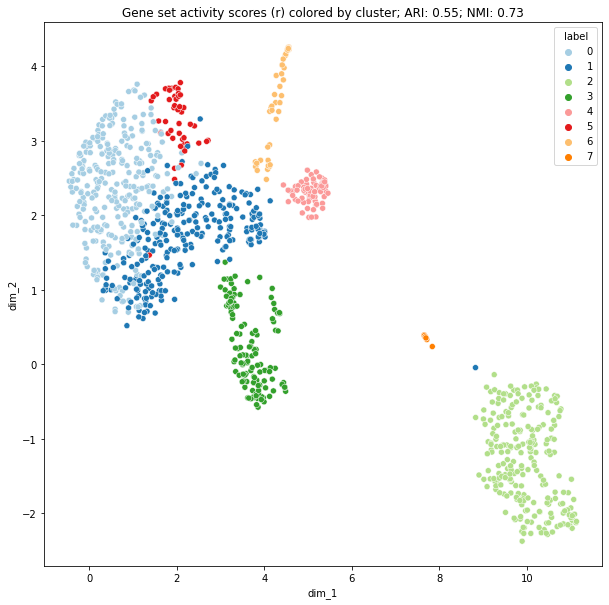

In [13]:
# perform leiden clustering on the learned gene set activity scores
adata = sc.AnnData(X=z_gene_set)
adata.obsm['X_vati'] = z_gene_set
sc.pp.neighbors(adata, n_pcs=gene_set_dim, use_rep='X_vati')
sc.tl.leiden(adata, resolution=1)
clusters_pre = adata.obs['leiden'].astype('int').values  # original as string

# metrics
if clusters_true is not None:
    # load subset index for calculating ARI
    if N > 5e4:
        idx_stratified, _ = train_test_split(range(N), test_size=0.5, stratify=clusters_true)
    else:
        idx_stratified = range(N)
    ari_smaller = adjusted_rand_score(clusters_pre[idx_stratified],
                                      clusters_true[idx_stratified])
    nmi_smaller = adjusted_mutual_info_score(clusters_pre, clusters_true)
    print(f"R: ARI for smaller cluster: {ari_smaller}")
    print(f"R: NMI for smaller cluster: {nmi_smaller}")
else:
    ari_smaller = np.nan
    nmi_smaller = np.nan


# color by cluster
umap_original = umap.UMAP().fit_transform(z_gene_set)

hues = {'label': clusters_true, 'cluster': clusters_pre}
for k, v in hues.items():
    df_plot = pd.DataFrame(umap_original)
    if v is None:
        df_plot['label'] = np.repeat("Label not available", df_plot.shape[0])
    else:
        df_plot['label'] = v
    df_plot['label'].astype('str')
    df_plot.columns = ['dim_1', 'dim_2', 'label']

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='dim_1', y='dim_2', hue='label', data=df_plot, palette="Paired", legend=True)
    plt.title(f"Gene set activity scores (r) colored by {k}; ARI: {round(ari_smaller, 2)}; NMI: {round(nmi_smaller, 2)}")
#     plt.savefig(os.path.join(r_folder, f"r_{r_epoch}_{k}.png"), bbox_inches="tight", format="png")
    plt.show()
    plt.close()


# 4. Pretrain AnnoCluster & initialize clustering
<a id=4></a>

Pretrain the AnnoCluster model, obtain the initial low-dimensional representations z_e of cells and initialize the clustering using Leiden clustering. 

The outputs from this step are:

    1. Pretrained AnnoCluster model (input_ae_path)
    2. Initial z_e / low-dimensional representation of samples (input_z_path)
    3. Initialized cluster assignment (input_cluster_path)
    4. Training stats (i.e. Trainining loss, validation loss etc.)

In [14]:
# ------ Pretrain annocluster & initialize clustering ------
model_autoencoder = autoencoder(input_dim=G, z_dim=z_dim, gene_set_dim=gene_set_dim,
                                encoder_dim=z_encoder_dim, emission_dim=z_decoder_dim,
                                num_layers_encoder=z_encoder_layers, num_layers_decoder=z_decoder_layers,
                                reconstruction_network='gaussian', decoding_network='gaussian',
                                use_cuda=use_cuda)

if os.path.isfile(input_z_path) and os.path.isfile(input_ae_path):
    print(f"Both pretrained autoencoder and inferred z exist. No need to pretrain the annocluster model.")
    z_init = np.load(input_z_path)
    model_autoencoder.load_state_dict(torch.load(input_ae_path)['state_dict'])
else:
    if os.path.isfile(input_ae_path):
        model_autoencoder.load_state_dict(torch.load(input_ae_path)['state_dict'])

    trainer = Trainer(dataset=expression_only, model=model_autoencoder, model_name="pretrain_z", batch_size=batch_size,
                      num_epochs=num_epochs_z, save_infer=True, output_folder=pretrain_z_folder, num_workers=num_workers,
                      use_cuda=use_cuda)

    if os.path.isfile(input_ae_path):
        print(f"Only pretrained autoencoder exists. Need to infer z and no need to pretrain the annocluster model.")
        z_init = trainer.infer_z()
        np.save(input_z_path, z_init)
    else:
        print(f"Start training pretrain the annocluster model ... ")
        trainer.train()
        z_init = np.load(input_z_path)

z_init = torch.from_numpy(z_init)

  0%|          | 0/9 [00:00<?, ?it/s]

Start training pretrain the annocluster model ... 
Current epoch: 0
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 1
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 2
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 3
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 4
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 5
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 6
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 7
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 8
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 9
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 10
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 11
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 12
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 13
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 14
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 15
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 16
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 17
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 18
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 19
Start training...


100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


In [15]:
try:
    z_init = z_init.numpy()
except AttributeError:
    pass

In [16]:
# initialize using leiden clustering
adata = sc.AnnData(X=z_init)
adata.obsm['X_unifan'] = z_init
sc.pp.neighbors(adata, n_pcs=z_dim,  use_rep='X_unifan', random_state=random_seed)
sc.tl.leiden(adata, resolution=1, random_state=random_seed)
clusters_pre = adata.obs['leiden'].astype('int').values  # original as string

# save for the dataset for classifier training
np.save(input_cluster_path, clusters_pre)

# initialize centroids
try:
    df_cluster = pd.DataFrame(z_init.detach().cpu().numpy())
except AttributeError:
    df_cluster = pd.DataFrame(z_init)

cluster_labels = np.unique(clusters_pre)
M = len(set(cluster_labels))  # set as number of clusters
df_cluster['cluster'] = clusters_pre

# get centroids
centroids = df_cluster.groupby('cluster').mean().values
centroids_torch = torch.from_numpy(centroids)

### visualize & evaluate the initial low-dimensional rerpesentations 

    1. visualize using UMAP
    2. evaluate the initialization by comparing with the ground truth (if available)

R: ARI for smaller cluster: 0.2890107483295252
R: NMI for smaller cluster: 0.6484405686250209


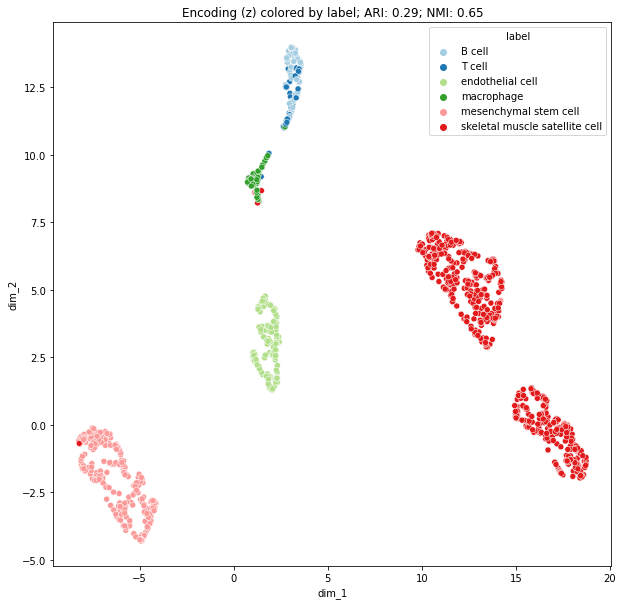

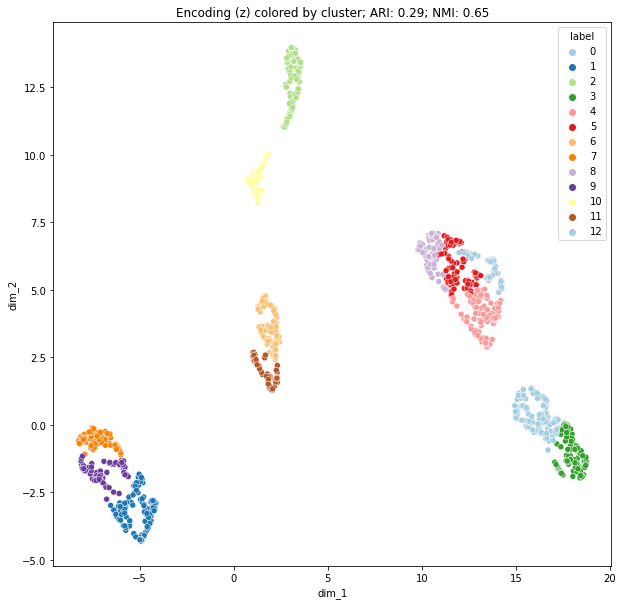

In [17]:
if clusters_true is not None:
    # load subset index for calculating ARI
    if N > 5e4:
        idx_stratified, _ = train_test_split(range(N), test_size=0.5, stratify=clusters_true)
    else:
        idx_stratified = range(N)
    ari_smaller = adjusted_rand_score(clusters_pre[idx_stratified],
                                      clusters_true[idx_stratified])
    nmi_smaller = adjusted_mutual_info_score(clusters_pre, clusters_true)
    print(f"R: ARI for smaller cluster: {ari_smaller}")
    print(f"R: NMI for smaller cluster: {nmi_smaller}")
else:
    ari_smaller = np.nan
    nmi_smaller = np.nan

umap_original = umap.UMAP().fit_transform(z_init)

# color by cluster
hues = {'label': clusters_true, 'cluster': clusters_pre}
for k, v in hues.items():
    df_plot = pd.DataFrame(umap_original)
    if v is None:
        df_plot['label'] = np.repeat("Label not available", df_plot.shape[0])
    else:
        df_plot['label'] = v
    df_plot['label'].astype('str')
    df_plot.columns = ['dim_1', 'dim_2', 'label']

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='dim_1', y='dim_2', hue='label', data=df_plot, palette="Paired",
                    legend=True)
    plt.title(f"Encoding (z) colored by {k}; ARI: {round(ari_smaller, 2)}; NMI: {round(nmi_smaller, 2)}")
#     plt.savefig(os.path.join(pretrain_z_folder, f"z_{z_epoch}_{k}.png"), bbox_inches="tight", format="png")
    plt.show()
    plt.close()

# 5. Pretrain annotator (classification)
<a id=5></a>

Pretrain the annotator model, using the initialized cluster assignments as true labels. The weight_decay hypeparameter is automatically selected based on the training accuracy.

The outputs from this step are:

    1. Pretrained annotator model
    2. Training stats (i.e. Trainining loss, validation loss etc.)

In [18]:
# ------ pretrain annotator (classification) ------
cls_times = 1  # count how many times of running classification
cls_training_accuracy = 1  # initialize being 1 so that to run at least once
weight_decay_candidates = [50, 20, 10, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1, 5e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
idx_starting_weight_decay = weight_decay_candidates.index(weight_decay)

while cls_training_accuracy >= 0.99:

    # assign new weight decay (first time running kepted the same)
    weight_decay = weight_decay_candidates[idx_starting_weight_decay - cls_times + 1]

    print(f"Run classifier the {cls_times}th time with {weight_decay}")

    prior_cluster = NumpyDataset(input_r_path, input_cluster_path)

    model_classifier = classifier(output_dim=M, z_dim=gene_set_dim, emission_dim=128, use_cuda=use_cuda)

    trainer = Trainer(dataset=prior_cluster, model=model_classifier, model_name="pretrain_annotator", batch_size=32,
                      num_epochs=num_epochs_classifier, save_infer=False, output_folder=pretrain_annotator_folder,
                      num_workers=num_workers, use_cuda=use_cuda)

    trainer.train(weight_decay=weight_decay)
    clusters_classifier = trainer.infer_annotator()
    
    cls_training_accuracy = (clusters_classifier.numpy() == clusters_pre).sum() / N
    print(f"Cluster accuracy on training: \n {cls_training_accuracy}")

    cls_times += 1

  0%|          | 0/35 [00:00<?, ?it/s]

Run classifier the 1th time with 0.001
Current epoch: 0
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 1
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 2
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 3
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 4
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 5
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 6
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 7
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 8
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 9
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 10
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 11
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 12
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 13
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 14
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 15
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 16
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 17
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 18
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 19
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Cluster accuracy on training: 
 1.0
Run classifier the 2th time with 0.01
Current epoch: 0
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 1
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 2
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 3
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 4
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 5
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 6
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 7
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 8
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 9
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 10
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 11
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 12
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 13
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 14
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 15
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 16
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 17
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 18
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 19
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Cluster accuracy on training: 
 0.9990925589836661
Run classifier the 3th time with 0.1
Current epoch: 0
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 1
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 2
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 3
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 4
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 5
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 6
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 7
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 8
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 9
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 10
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 11
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 12
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 13
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 14
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 15
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 16
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 17
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 18
Start training...


  0%|          | 0/35 [00:00<?, ?it/s]

Current epoch: 19
Start training...


100%|██████████| 35/35 [00:00<00:00, 65.63it/s]


Cluster accuracy on training: 
 0.956442831215971


# 6. Clustering using AnnoCluster together with annotator
<a id=6></a>

We train the annotator together with the AnnoCluster (the encoder and decoder (e) \& decoder(q)). In each epoch, the annotator is trained by using the clustering results as the true label for each cell. The output from the annotator p(r) is in turn used to evaluate the annotator loss for the AnnoCluster. The annotator is optimized using its own loss function, separately from the AnnoCluster model. 

We will print out the ARI and NMI evaluated based on the final cluster assignment result, if the ground truth is available. 

The outputs from this step are:

    1. Trained AnnoCluster and annotator model (saved in one single file)
    2. Cluster assignments (annocluster_clusters_pre_{training epochs - 1}.npy)
    3. low-dimensional representations (z_e) of cells (annocluser_{training epochs - 1}.npy)
    4. Training stats (i.e. Trainining loss, validation loss, loss for different terms, ARI and NMI based on the final clustering results etc.)

In [19]:
# ------ clustering ------
num_epochs = num_epochs_annocluster 
use_pretrain = True

model_annocluster = AnnoCluster(input_dim=G, z_dim=z_dim, gene_set_dim=gene_set_dim, tau=tau, n_clusters=M,
                                encoder_dim=z_encoder_dim, emission_dim=z_decoder_dim, 
                                num_layers_encoder=z_encoder_layers, num_layers_decoder=z_decoder_layers, 
                                use_t_dist=True, reconstruction_network='gaussian', decoding_network='gaussian', 
                                centroids=centroids_torch, gene_set_table=gene_set_matrix, use_cuda=use_cuda)

if use_pretrain:
    pretrained_state_dict = model_autoencoder.state_dict()

    # load pretrained AnnoCluster model
    state_dict = model_annocluster.state_dict()
    for k, v in state_dict.items():
        if k in pretrained_state_dict.keys():
            state_dict[k] = pretrained_state_dict[k]

    model_annocluster.load_state_dict(state_dict)

# reload dataset, loading gene set activity scores together
expression_prior = AnnDataset(data_filepath, second_filepath=input_r_path, label_name=label_name)

trainer = Trainer(dataset=expression_prior, model=model_annocluster, model_2nd=model_classifier,
                  model_name="annocluster", batch_size=batch_size, num_epochs=num_epochs_annocluster,
                  save_infer=True, output_folder=annocluster_folder, num_workers=num_workers, use_cuda=use_cuda)
trainer.train(weight_decay=weight_decay)


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 0
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Start evaluating val...
Current epoch: 1
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 2
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 3
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 4
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 5
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 6
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 7
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 8
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 9
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 10
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Start evaluating val...
Current epoch: 11
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 12
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 13
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 14
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 15
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 16
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 17
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 18
Start training...


  0%|          | 0/9 [00:00<?, ?it/s]

Current epoch: 19
Start training...


100%|██████████| 9/9 [00:01<00:00,  5.06it/s]

annocluster: ARI for smaller cluster: 0.9643899702436854
annocluster: NMI for smaller cluster: 0.9406709442958107
